In [51]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import scipy
from matplotlib import pyplot as plt
from scipy import interpolate
import numpy.ma as ma
from skimage import data, color
from skimage.transform import rescale, resize, downscale_local_mean

ModuleNotFoundError: No module named 'skimage'

## Part 1

In [7]:
def projectPoints(im1, im2, N):
    p1, p2 = getPoints(im1, im2, N)
    H = computeH(p1, p2)
    fig1.suptitle('Choose an arbitrary point from the left image')
    plt.draw()
    arbitraryPoint = np.asarray(fig1.ginput(n=1, timeout=-1)[0])
    axes1[0].scatter(arbitraryPoint[0], arbitraryPoint[1], marker='x',
                     color='green')
    plt.draw()
    arbitraryPoint = np.array([arbitraryPoint[0], arbitraryPoint[1], 1])
    projectedPoint = np.matmul(H, arbitraryPoint)
    projectedPoint = projectedPoint / projectedPoint[-1]
    axes1[1].scatter(projectedPoint[0], projectedPoint[1], marker='o',
                     color='green')
    fig1.suptitle('The green circle on the right image is the corresponding '
                  'point')
    plt.draw()
    plt.savefig("../output/Section 1.2 - Transformation Correctness "
                "Example.png")


In [8]:
def getPoints(im1, im2, N):
    fig1, axes1 = plt.subplots(1, 2)
    axes1[0].imshow(im1)
    axes1[1].imshow(im2)
    axes1[0].set_xticks([])
    axes1[0].set_yticks([])
    axes1[1].set_xticks([])
    axes1[1].set_yticks([])
    fig1.suptitle(f'Click on {N} corresponding points on each image, '
                  f'in alternating order, starting from the left image')

    p1 = []
    p2 = []

    while len(p1) + len(p2) < 2 * N:
        p1.append(np.asarray(fig1.ginput(n=1, timeout=-1)[0]))
        axes1[0].scatter(p1[-1][0], p1[-1][1], marker='x', color='red')
        plt.draw()
        p2.append(np.asarray(fig1.ginput(n=1, timeout=-1)[0]))
        axes1[1].scatter(p2[-1][0], p2[-1][1], marker='x', color='blue')
        plt.draw()
    p1 = np.array(p1)
    p2 = np.array(p2)
    return p1.T, p2.T

In [10]:
im1 = cv2.imread('./data/incline_L.png')
im1 = cv2.cvtColor(im1, cv2.COLOR_BGR2RGB)
im2 = cv2.imread('./data/incline_R.png')
im2 = cv2.cvtColor(im2, cv2.COLOR_BGR2RGB)
#p1, p2 = getPoints(im1, im2, 6)
p1 = np.array([[454.5436828, 511.94919355, 602.95793011, 623.95994624,
                    640.76155914, 612.75887097], [110.43200202, 111.83213642,
                                                  484.26788911, 481.4676203,
                                                  482.8677547, 197.24033535]])
p2 = np.array([[118.05591398, 185.7, 294.24516129, 316.2688172,
                    335.14623656, 294.24516129],
                   [151.48032796, 154.62656452, 536.89430645, 535.32118817,
                    532.17495161, 244.29430645]])

In [72]:
def computeH(p1, p2):
    assert (p1.shape[1] == p2.shape[1])
    assert (p1.shape[0] == 2)

    N = p1.shape[1]
    A = np.zeros((2 * N, 9))

    p2 = np.vstack([p2, np.ones(N)])
    A[range(0, 2 * N, 2), 0:3] = p2.T
    A[range(1, 2 * N, 2), 3:6] = p2.T
    A[range(0, 2 * N, 2), 6:8] = -p2[0:2].T * np.array([p1[0], p1[0]]).T
    A[range(1, 2 * N, 2), 6:8] = -p2[0:2].T * np.array([p1[1], p1[1]]).T
    A[range(0, 2 * N, 2), 8] = -p1[0].T
    A[range(1, 2 * N, 2), 8] = -p1[1].T

    _lambda, V = np.linalg.eig(np.matmul(A.T, A))
    indexOfSmallestLambda = np.abs(_lambda).argmin()
    H2to1 = V[:, indexOfSmallestLambda].reshape(3, 3)

    return H2to1

In [84]:
    H2to1 = computeH(p1, p2)

In [14]:
def computeOutSize(im1, im2, H1to2):
    upper_left_corner = H1to2 @ np.array([0, 0, 1]).T
    upper_left_corner = upper_left_corner / upper_left_corner[2]

    buttom_left_corner = H1to2 @ np.array([0, im1.shape[0], 1]).T
    buttom_left_corner = buttom_left_corner / buttom_left_corner[2]

    out_size = (int(np.ceil(abs(buttom_left_corner[1]) + abs(upper_left_corner[1]))), int(np.ceil(abs(im2.shape[1]) + abs(upper_left_corner[0]))), 3)
    return out_size


In [18]:
def create_mesh_indices(dims):
    """ create array of mesh indices with the 'dims' dimension """
    x_indices = np.arange(0, dims[1])  # all indices for out size
    y_indices = np.arange(0, dims[0])
    indices = np.array(np.meshgrid(x_indices, y_indices)).transpose([1, 2, 0])  # create array on indices
    return indices

def calculate_transformed_indices_from_homography(H, indices):
    """ transform indices use homography H """
    orig_shape = indices.shape
    indices = indices.reshape(-1, 2)  # flatten to single dim array of indices
    transformed = np.hstack([indices, np.ones((indices.shape[0], 1))])  # convert to homogeneous indices
    transformed = (H @ transformed.transpose()).transpose()  # compute transformation
    transformed = (transformed / (transformed[:, 2])[:, np.newaxis])[:, 0:2]  # switch back to heterogeneous coordinates
    transformed = transformed.reshape(orig_shape)
    return transformed

def calculate_warped_dims(original_shape, H):
    """ calculate the output dimension and translation for
    warping a image with shape 'original_shape' using homography H """
    indices = create_mesh_indices(original_shape)
    transformed_dims = calculate_transformed_indices_from_homography(H, indices)
    max_x = np.max(transformed_dims[:, :, 0])
    min_x = np.min(transformed_dims[:, :, 0])
    max_y = np.max(transformed_dims[:, :, 1])
    min_y = np.min(transformed_dims[:, :, 1])
    warped_dims = (np.round(max_y - min_y).astype('int'), np.round(max_x - min_x).astype('int'))
    return warped_dims 

In [70]:
def warpH(im1, H2to1, out_size, interpolation_type='linear'):
    epsilon = 10e-15

    # Split im1 into channels
    red_channel_im1 = im1[:, :, 0]
    green_channel_im1 = im1[:, :, 1]
    blue_channel_im1 = im1[:, :, 2]

    # Create channels of output image
    warp_im1_red_channel = np.zeros(out_size[:2])
    warp_im1_green_channel = np.zeros(out_size[:2])
    warp_im1_blue_channel = np.zeros(out_size[:2])

    # Create mappings for interpolation
    upper_left_corner = H2to1 @ np.array([0, 0, 1]).T
    upper_left_corner = upper_left_corner / (upper_left_corner[2] + epsilon)

    bottom_left_corner = H2to1 @ np.array([0, out_size[0], 1]).T
    bottom_left_corner = bottom_left_corner / (bottom_left_corner[2] + epsilon)

    upper_right_corner = H2to1 @ np.array([out_size[1], 0, 1]).T
    upper_right_corner = upper_right_corner / (upper_right_corner[2] + epsilon)

    x_grid = np.linspace(upper_left_corner[0], upper_right_corner[0], im1.shape[1])
    y_grid = np.linspace(upper_left_corner[1], bottom_left_corner[1], im1.shape[0])

    # Interpolate by channel
    f_red = interpolate.interp2d(x_grid, y_grid, red_channel_im1,
                                 kind=interpolation_type,
                                 fill_value=0)

    f_green = interpolate.interp2d(x_grid, y_grid, green_channel_im1,
                                   kind=interpolation_type,
                                   fill_value=0)

    f_blue = interpolate.interp2d(x_grid, y_grid, blue_channel_im1,
                                  kind=interpolation_type,
                                  fill_value=0)

    for y in range(out_size[0]):
        for x in range(out_size[1]):
            new_coords = H2to1 @ np.array([x, y, 1]).T
            new_coords = new_coords / (new_coords[2] + epsilon)
            red_value = f_red(new_coords[0], new_coords[1])
            green_value = f_green(new_coords[0], new_coords[1])
            blue_value = f_blue(new_coords[0], new_coords[1])
            warp_im1_red_channel[y, x] = red_value
            warp_im1_green_channel[y, x] = green_value
            warp_im1_blue_channel[y, x] = blue_value

    warp_im1 = np.zeros((out_size[0], out_size[1], 3))
    warp_im1[:, :, 0] = warp_im1_red_channel
    warp_im1[:, :, 1] = warp_im1_green_channel
    warp_im1[:, :, 2] = warp_im1_blue_channel
    warp_im1 = warp_im1.astype(np.uint8)
    return warp_im1


In [20]:
testWarped1 = warpH(im1, H2to1, calculate_warped_dims(im1.shape, np.linalg.inv(H2to1)), interpolation_type='linear')
#testWarped2 = warpH(im1, H2to1, calculate_warped_dims(im1.shape, np.linalg.inv(H2to1)), interpolation_type='cubic')

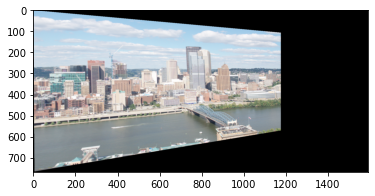

In [21]:
# im1 axis alignment
H1to2 = np.linalg.inv(H2to1)
out_size = computeOutSize(im1, im2, np.linalg.inv(H2to1))
im1_aligned = np.zeros(out_size, dtype='uint8')
im1_mask = np.where(testWarped1 != [0, 0, 0])
im1_aligned[im1_mask] = testWarped1[im1_mask]
plt.imshow(im1_aligned)

im2_aligned = np.zeros(out_size, dtype='uint8')

# calculate how much to move down - y axis
upper_left_corner = H1to2 @ np.array([0, 0, 1]).T
upper_left_corner = upper_left_corner / upper_left_corner[2]
y = abs(int(np.ceil(upper_left_corner[1])))

# calculate how much to move right - x axis
x = out_size[1] - im2.shape[1]

im2_mask = np.where(im2 != [0, 0, 0])
im2_aligned[im2_mask[0] + y, im2_mask[1] + x, im2_mask[2]] = im2[im2_mask]



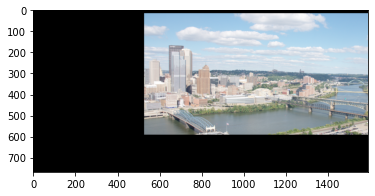

In [22]:
plt.imshow(im2_aligned)


In [23]:
def imageStitching(img1, warp_img2):
    panoImg = img1
    img1_mask = np.where(img1 == [0, 0, 0])
    panoImg[img1_mask] = warp_img2[img1_mask]
    return panoImg

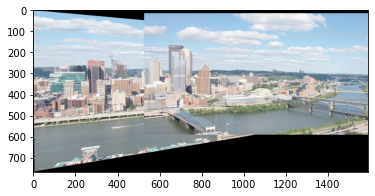

In [24]:

plt.imshow(imageStitching(im2_aligned, im1_aligned))

In [67]:
# def getPoints_SIFT(im1, im2):

#   # Initiate the SIFT detector
#   sift = cv2.xfeatures2d.SIFT_create()

#   # Find the keypoints and descriptors
#   kp_im1, desc_im1 = sift.detectAndCompute(im1, None)
#   kp_im2, desc_im2 = sift.detectAndCompute(im2, None)

#   # Match keypoints using L2 norm - documentation said that it is good for SIFT
#   # Use crossCheck=true which ensures that the matcher returns only those matches 
#   # with value (i,j) such that i-th descriptor in set A has j-th descriptor in 
#   # set B as the best match and vice-versa.
#   brute_force = cv2.BFMatcher(cv2.NORM_L2, crossCheck=True)

#   # Get best matches of the two images
#   matches = brute_force.match(desc_im1, desc_im2)
  
#   # Sort them in the order of their distance.
#   matches = sorted(matches, key = lambda x:x.distance)

#   p1 = np.array([ kp_im1[m.queryIdx].pt for m in matches ]).T
#   p2 = np.array([ kp_im2[m.trainIdx].pt for m in matches ]).T

#   return p1, p2

def getPoints_SIFT(im1, im2):
    #cv2.cvtColor(panoImg , cv2.COLOR_BGR2RGB)
    
    FLANN_INDEX_KDTREE = 2
    sift = cv2.xfeatures2d.SIFT_create()
    kp1, des1 = sift.detectAndCompute(im1, None)
    kp2, des2 = sift.detectAndCompute(im2, None)
    index = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
    search = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index,search)
    matches = flann.knnMatch(des1, des2, k=2)
    mask = [[0, 0] for i in range(len(matches))]
    p1, p2 = [], []
    for i,(m,n) in enumerate(matches):
        if m.distance < 0.5*n.distance:
            mask[i] = [1, 0]
            p1.append(kp1[m.queryIdx].pt)
            p2.append(kp2[m.trainIdx].pt)
    draw_params = dict(matchColor = (0, 255, 0),
                   singlePointColor = (255, 0, 0),
                   matchesMask = mask,
                   flags = 0)
    im3 = cv2.drawMatchesKnn(cv2.cvtColor(im1 , cv2.COLOR_BGR2RGB), kp1, cv2.cvtColor(im2 , cv2.COLOR_BGR2RGB), kp2, matches, None, **draw_params)
    #plt.imshow(im3)
    plt.show()
    p1 = np.array(p1).T
    p2 = np.array(p2).T
    return np.uint64(p1), np.uint64(p2)

In [87]:
def calculate_outsize_and_offset(im1, im2, H):
    """
      Input:
          im1           - colored image that is static in the panorama stitching
          im2           - colored image that is taking place in warping and then panorama stitching
          H             - homography matrix for projecting im2 to other image's plane
      Output:
          output_shape  -  the height and width of the panorama image of im1, im2
          offset_h      - offset in height for the images creating the panorama, using to keep their coordinates positive
          offset_w      - offset in width for the images creating the panorama, using to keep their coordinates positive
      """
    h1, w1 = im1.shape[:2]
    h2, w2 = im2.shape[:2]

    # coordinates of the corners of img2
    corner = np.array([[0, w2, 0, w2],
                       [0, 0, h2, h2],
                       [1, 1, 1, 1]])
    # find the new coordinates of the corners of img2 after warping
    warp_corner = H @ corner
    for i in range(3):
        warp_corner[i, :] /= warp_corner[-1, :]
    warp_corner = np.ceil(warp_corner)

    # calculate the maximum shape of the warped image
    max_h = max(np.max(warp_corner[1, :]), h1)
    min_h = min(np.min(warp_corner[1, :]), 0)
    max_w = max(np.max(warp_corner[0, :]), w1)
    min_w = min(np.min(warp_corner[0, :]), 0)

    # offset needed for both images:
    offset_w = int(min(min_w, 0))
    offset_h = int(min(min_h, 0))

    width = int(max_w) - offset_w
    height = int(max_h) - offset_h

    output_shape = (height, width)
    return output_shape#, offset_h, offset_w

def computeH2(p1, p2):
    """
      Input:
      p1 and p2 - Each are size (2 x N) matrices of corresponding (x,y)' coordinates between two images
      Output:
      H2to1 - matrix 3x3 encoding the homography that best matches the linear equation
    """
    assert (p1.shape[1] == p2.shape[1])
    assert (p1.shape[0] == 2)

    N = p1.shape[1]
    xi = p1[0, :].T
    yi = p1[1, :].T
    ui = p2[0, :].T
    vi = p2[1, :].T

    # build A
    A1 = np.array([-1*ui.T, -1*vi.T, -1*np.ones(N), np.zeros(N), np.zeros(N), np.zeros(N), (xi*ui).T, (xi*vi).T, xi.T]).T
    A2 = np.array([np.zeros(N), np.zeros(N), np.zeros(N), -1*ui.T, -1*vi.T, -1*np.ones(N), (yi*ui).T, (yi*vi).T, yi.T]).T
    A = np.concatenate((A1, A2), axis=0)

    # # svd
    # U, S, V = np.linalg.svd(A)
    # H2to1 = V[-1]
    # H2to1 = H2to1.reshape((3, 3))

    D, V = np.linalg.eig(A.T @ A)
    id_min = np.argmin(D)
    H2to1 = V[:, id_min].reshape((3, 3))
    return H2to1

[[-1.16616407e-03  6.78660841e-04 -9.95299613e-01]
 [ 2.18510332e-04 -1.43538126e-03 -9.67934569e-02]
 [ 8.95732810e-07  9.54618493e-07 -2.40378771e-03]]


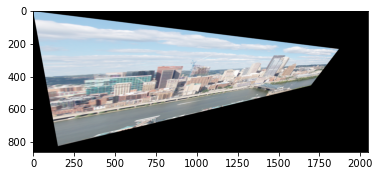

In [89]:
p1_SIFT, p2_SIFT = getPoints_SIFT(im1, im2)
H_SIFT_2to1 = computeH2(p1_SIFT[:6], p2_SIFT[:6])
print(H_SIFT_2to1)
warped_im1_SIFT = warpH(im1, H_SIFT_2to1, calculate_outsize_and_offset(im1, im2, H_SIFT_2to1), interpolation_type='linear')
plt.imshow(warped_im1_SIFT)